In [814]:
import lightkurve
import eleanor
import pickle
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import statsmodels.api as sm
from astropy.table import Table
from astropy.coordinates import SkyCoord
from lightkurve import search_lightcurvefile
from numpy import loadtxt
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
from astropy.io import fits
from lowess_detrend import lowess_detrending
from utility_belt import phase_fold_plot
from astropy.timeseries import BoxLeastSquares
from lc_download_methods import two_min_lc_download
plt.ion()

Setup

In [815]:
save_path = '/Users/mbattley/Documents/PhD/Kepler-2min xmatch/'
#target_ID = "96152143"
#sector=12
target_ID = "273234825"
TIC = int(target_ID)
sector=14
multi_sector = False
planet_present = True

Optional: Get planet/candidate details from file

In [816]:
data = Table.read(save_path + 'Kepler_pcs_reobserved_in_TESS_2min_final.csv', format='ascii.csv')
for j in range(len(data['TICID'])):
    if data['TICID'][j] == int(target_ID):
        period = data['koi_period'][j]
        t0 = data['koi_time0'][j]
        KIC = 'KIC '+ str(data['kepid'][j])
        i=j

print("Period = {:.5}d".format(period))
print("t0 = {}".format(t0))
print(KIC)

Period = 330.07d
t0 = 2455173.987
KIC 7303287


Read in TESS data

In [817]:
if (data['S14'][i] != 0) and (data['S15'][i] != 0) and (data['S26'][i] != 0):
    multi_sector = [14,15,26]
elif (data['S14'][i] != 0) and (data['S15'][i] != 0):
    multi_sector = [14,15]
elif (data['S14'][i] != 0) and (data['S26'][i] != 0):
    multi_sector = [14,26]
print(multi_sector)

#multi_sector = [14,15]
#multi_sector = False
if multi_sector != False:
    sap_lc, sap_lc = two_min_lc_download(TIC, sector = multi_sector[0], from_file = False)
    lc = pdcsap_lc
    nancut = np.isnan(lc.flux) | np.isnan(lc.time)
    lc = lc[~nancut]
    lc.flux = np.array(lc.flux)/np.median(lc.flux)
    for sector_num in multi_sector[1:]:
        sap_lc_new, pdcsap_lc_new = two_min_lc_download(TIC, sector_num, from_file = False)
        lc_new = pdcsap_lc_new
        nancut = np.isnan(lc_new.flux) | np.isnan(lc_new.time)
        lc_new = lc_new[~nancut]
        lc_new.flux = np.array(lc_new.flux)/np.median(lc_new.flux)
        lc = lc.append(lc_new)
else:
    sap_lc, pdcsap_lc = two_min_lc_download(target_ID, sector = sector, from_file = False)
    lc = pdcsap_lc
    nancut = np.isnan(lc.flux) | np.isnan(lc.time)
    lc = lc[~nancut]
    #lcf = search_lightcurvefile(target_ID, sector=sector).download()
    #pdcsap_lc = lcf.PDCSAP_FLUX
    #header_0 = lcf
    #lc = pdcsap_lc
    #nancut = np.isnan(lc.flux) | np.isnan(lc.time)
    #lc = lc[~nancut]
    print('Removed nans')
time_TESS = np.array(lc.time) #n.b. in TJD (TESS Time)
time_TESS_orig = np.array([float(str(element).strip()) for element in time_TESS]) + 2457000 #Convert to BJD for consistency
flux_TESS = lc.flux
flux_TESS_orig = np.array(flux_TESS)/np.median(flux_TESS) -1 #Normalizes and sets mean to zero, as in exoplanet tutorial
flux_err_TESS = lc.flux_err/np.median(flux_TESS)
mean_flux_err_TESS = np.mean(flux_err_TESS)


[14, 15]
TIC 273234825
TIC 273234825


<IPython.core.display.Javascript object>


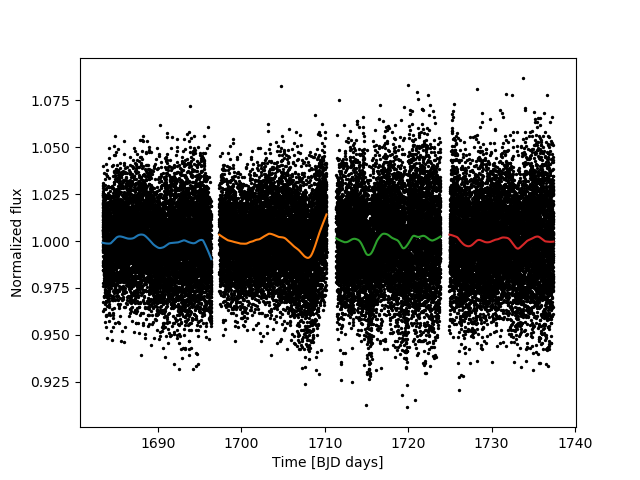

<IPython.core.display.Javascript object>


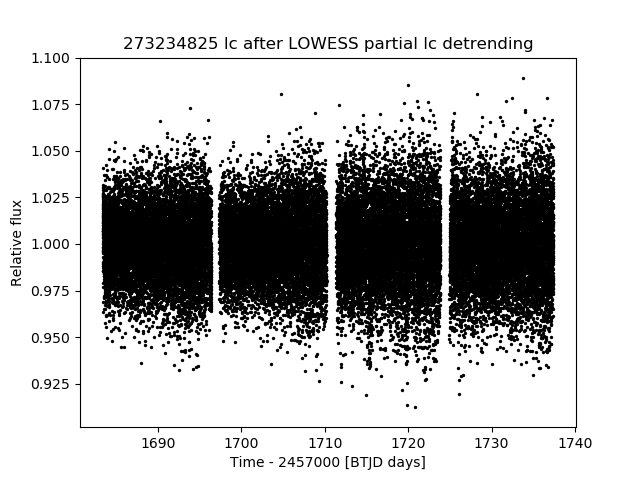

1474.7025800001975


<IPython.core.display.Javascript object>


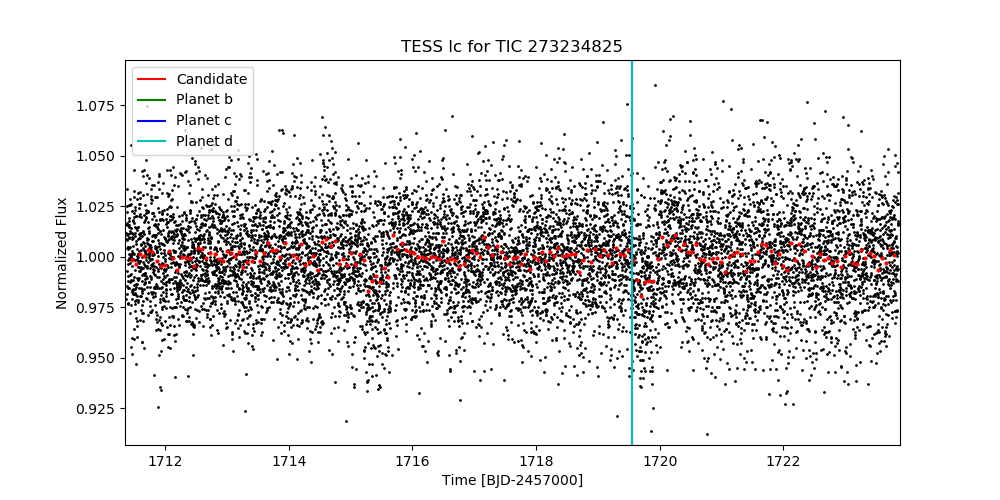

1661.955000000133
1593.7023999999547
1675.1943999998548


Text(0, 0.5, 'Normalized Flux')

In [827]:
from utility_belt import binned
from lowess_detrend import lowess_detrending

def get_init_t0s(t0,per,time):
    if time[0] < 2000:
        current_t0 = t0 - 2457000
    else:
        current_t0 = t0
    t0s = []
    while current_t0 - per > time[0]:
        current_t0 = current_t0 - per
    while current_t0 + per < time[0]:
        current_t0 = current_t0 + per
    print(current_t0)
    while current_t0 < time[-1]:
        t0s = t0s + [current_t0]
        current_t0 = current_t0 + per
        
    return t0s

detrended_TESS_flux, full_lowess_flux = lowess_detrending(flux=flux_TESS, time=time_TESS,target_ID=target_ID,n_bins=96)
flux_TESS = detrended_TESS_flux

binned_time, binned_flux = binned(time_TESS, flux_TESS, binsize=48)

t0s = get_init_t0s(t0,period,time_TESS)

plt.figure(figsize=(10,5))
plt.scatter(time_TESS,flux_TESS,s=1,c='k')
plt.scatter(binned_time, binned_flux,s=4,c='r')
first = True
for t0i in t0s:
    if first == True:
        plt.axvline(x=t0i, c='r',label='Candidate')
        first = False
    else:
        plt.axvline(x=t0i, c='r')
plt.title("TESS lc for TIC {}".format(target_ID))
plt.xlim(min(time_TESS)-1,max(time_TESS)+1)

# Optional: Plot planet epochs
if planet_present == True:
    planet_details = [[2454965.64,34.545],[2455069.852,125.8518],[2454975.644,66.0634]]
    t0s_b = get_init_t0s(planet_details[0][0],planet_details[0][1],time_TESS)
    t0s_c = get_init_t0s(planet_details[1][0],planet_details[1][1],time_TESS)
    t0s_d = get_init_t0s(planet_details[2][0],planet_details[2][1],time_TESS)
    first = True
    for t0i in t0s_b:
        if first == True:
            plt.axvline(x=t0i, c='g',label='Planet b')
            first = False
        else:
            plt.axvline(x=t0i, c='g')
    first = True
    for t0i in t0s_c:
        if first == True:
            plt.axvline(x=t0i, c='b',label='Planet c')
            first = False
        else:
            plt.axvline(x=t0i, c='b')
    first = True
    for t0i in t0s_c:
        if first == True:
            plt.axvline(x=t0i, c='c',label='Planet d')
            first = False
        else:
            plt.axvline(x=t0i, c='c')
plt.legend()
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')

In [819]:
t0s

[1474.7025800001975]

In [820]:
current_t0

1804.7741380001976

In [821]:
time_TESS[-1]

1737.4117808607639

<IPython.core.display.Javascript object>


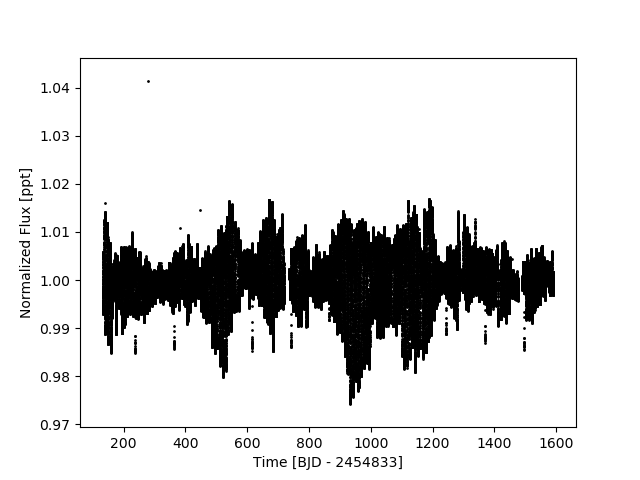

In [822]:
#KIC = 'KIC 8554498'
lcfs = lightkurve.search_lightcurvefile(KIC, mission='Kepler').download_all()
stitched_lc = lcfs.PDCSAP_FLUX.stitch()
nancut = np.isnan(stitched_lc.flux) | np.isnan(stitched_lc.time)
stitched_lc = stitched_lc[~nancut]
time_Kepler = np.array(stitched_lc.time) + 2454833 #Convert to BJD for consistency
flux_Kepler = np.array(stitched_lc.flux)/np.median(stitched_lc.flux)
orig_flux_Kepler = flux_Kepler
binned_Kepler_time, binned_Kepler_flux = binned(time_Kepler,flux_Kepler,binsize=2)

time = time_Kepler - 2454833
flux = flux_Kepler

plt.figure()  
plt.scatter(time,flux, c='k', s=1)
plt.xlabel("Time [BJD - 2454833]")
plt.ylabel("Normalized Flux [ppt]")
plt.show()

2455173.987


<IPython.core.display.Javascript object>


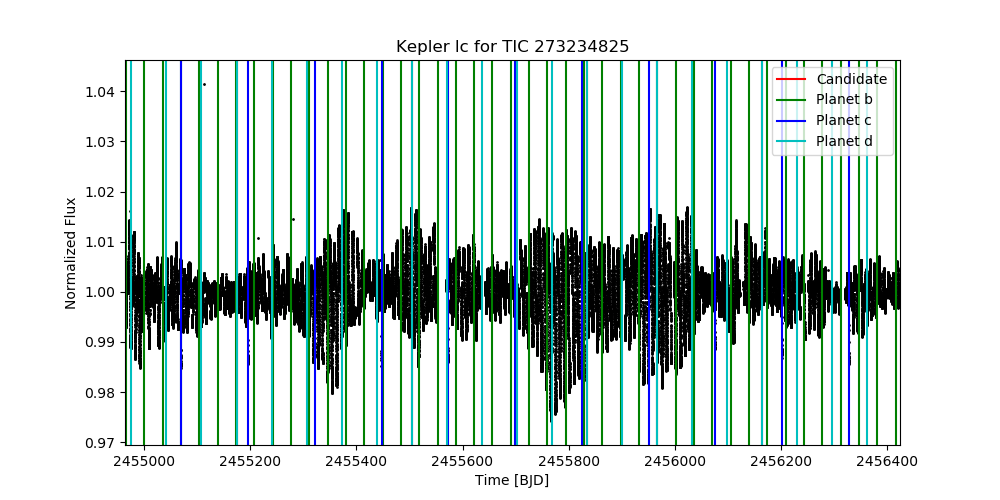

2454965.64
2455069.852
2454975.644


Text(0, 0.5, 'Normalized Flux')

In [823]:
t0s = get_init_t0s(t0,period,time_Kepler)

plt.figure(figsize=(10,5))
plt.scatter(time_Kepler,flux_Kepler,s=1,c='k')
#plt.scatter(binned_Kepler_time, binned_Kepler_flux,s=2,c='r')
first = True
for t0i in t0s:
    if first == True:
        plt.axvline(x=t0i, c='r',label='Candidate')
        first = False
    else:
        plt.axvline(x=t0i, c='r')
plt.title("Kepler lc for TIC {}".format(target_ID))
plt.xlim(min(time_Kepler)-1,max(time_Kepler)+1)

# Optional: Plot planet epochs
if planet_present == True:
    planet_details = [[2454965.64,34.545],[2455069.852,125.8518],[2454975.644,66.0634]]
    t0s_b = get_init_t0s(planet_details[0][0],planet_details[0][1],time_Kepler)
    t0s_c = get_init_t0s(planet_details[1][0],planet_details[1][1],time_Kepler)
    t0s_d = get_init_t0s(planet_details[2][0],planet_details[2][1],time_Kepler)
    first = True
    for t0i in t0s_b:
        if first == True:
            plt.axvline(x=t0i, c='g',label='Planet b')
            first = False
        else:
            plt.axvline(x=t0i, c='g')
    first = True
    for t0i in t0s_c:
        if first == True:
            plt.axvline(x=t0i, c='b',label='Planet c')
            first = False
        else:
            plt.axvline(x=t0i, c='b')
    first = True
    for t0i in t0s_d:
        if first == True:
            plt.axvline(x=t0i, c='c',label='Planet d')
            first = False
        else:
            plt.axvline(x=t0i, c='c')
plt.legend()
plt.xlabel('Time [BJD]')
plt.ylabel('Normalized Flux')

In [824]:
t0s

[2455173.987, 2455504.0585580003, 2455834.1301160003, 2456164.2016740004]

<IPython.core.display.Javascript object>


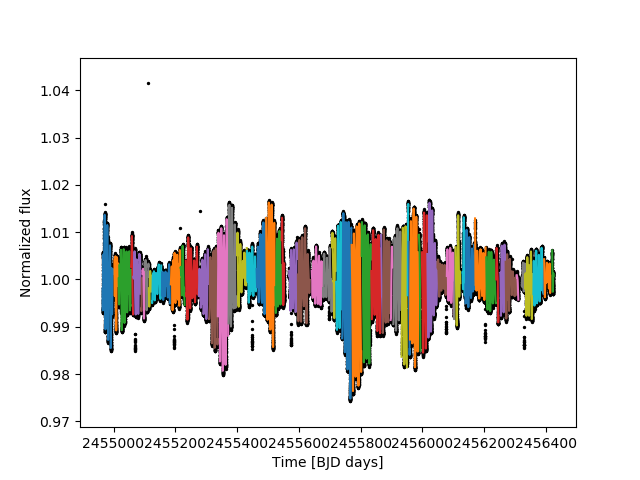

<IPython.core.display.Javascript object>


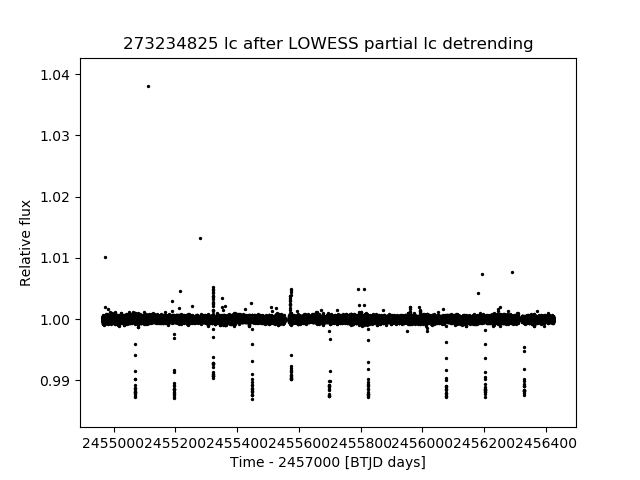

<IPython.core.display.Javascript object>


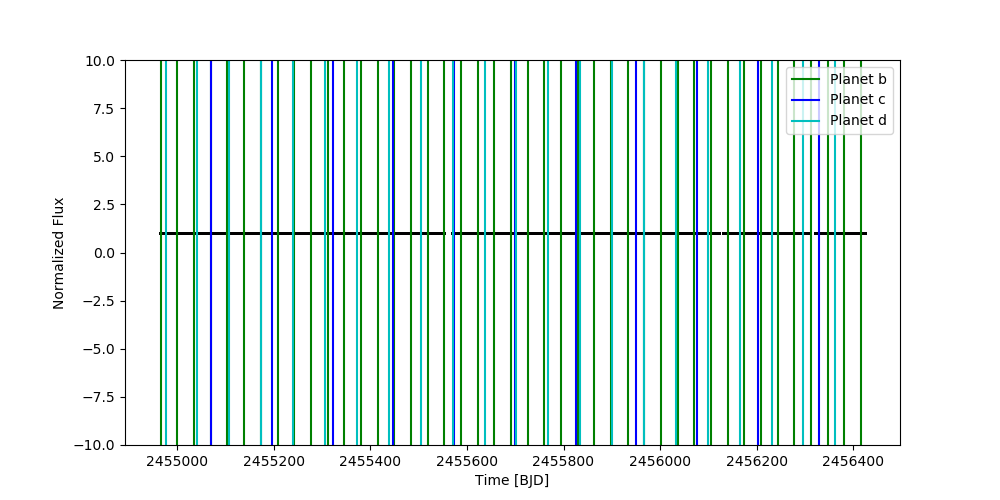

2454965.64
2455069.852
2454975.644


In [825]:
detrended_Kepler_flux, full_lowess_flux = lowess_detrending(flux=flux_Kepler, time=time_Kepler,target_ID=target_ID,n_bins=48,pipeline='Kepler')
flux_Kepler = detrended_Kepler_flux

plt.figure(figsize=(10,5))
plt.scatter(time_Kepler,flux_Kepler,s=1,c='k')
plt.xlabel('Time [BJD]')
plt.ylabel('Normalized Flux')
plt.ylim(-10,10)
if planet_present == True:
    planet_details = [[2454965.64,34.545],[2455069.852,125.8518],[2454975.644,66.0634]]
    t0s_b = get_init_t0s(planet_details[0][0],planet_details[0][1],time_Kepler)
    t0s_c = get_init_t0s(planet_details[1][0],planet_details[1][1],time_Kepler)
    t0s_d = get_init_t0s(planet_details[2][0],planet_details[2][1],time_Kepler)
    first = True
    for t0i in t0s_b:
        if first == True:
            plt.axvline(x=t0i, c='g',label='Planet b')
            first = False
        else:
            plt.axvline(x=t0i, c='g')
    first = True
    for t0i in t0s_c:
        if first == True:
            plt.axvline(x=t0i, c='b',label='Planet c')
            first = False
        else:
            plt.axvline(x=t0i, c='b')
    first = True
    for t0i in t0s_d:
        if first == True:
            plt.axvline(x=t0i, c='c',label='Planet d')
            first = False
        else:
            plt.axvline(x=t0i, c='c')
    plt.legend()

<IPython.core.display.Javascript object>


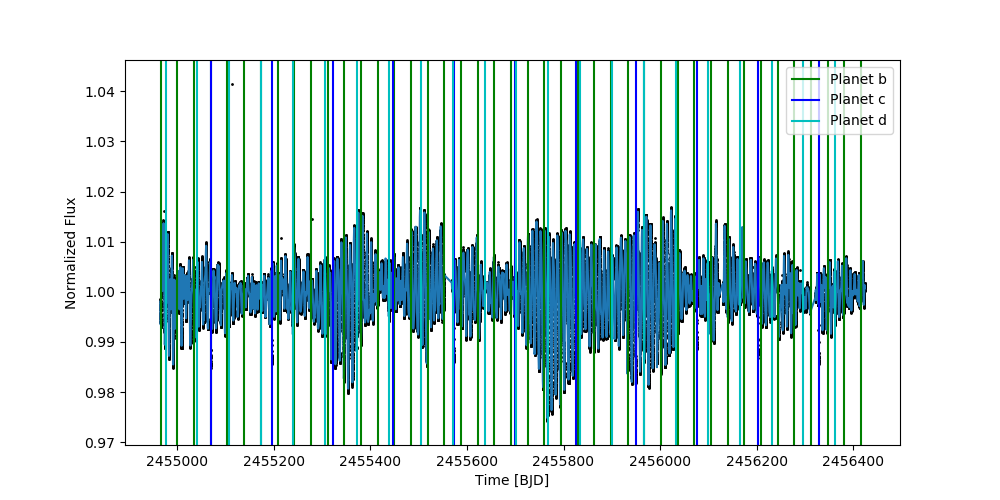

2454965.64
2455069.852
2454975.644


In [826]:
plt.figure(figsize=(10,5))
plt.scatter(time_Kepler,orig_flux_Kepler,s=1,c='k')
plt.plot(time_Kepler,full_lowess_flux)
plt.xlabel('Time [BJD]')
plt.ylabel('Normalized Flux')
if planet_present == True:
    planet_details = [[2454965.64,34.545],[2455069.852,125.8518],[2454975.644,66.0634]]
    t0s_b = get_init_t0s(planet_details[0][0],planet_details[0][1],time_Kepler)
    t0s_c = get_init_t0s(planet_details[1][0],planet_details[1][1],time_Kepler)
    t0s_d = get_init_t0s(planet_details[2][0],planet_details[2][1],time_Kepler)
    first = True
    for t0i in t0s_b:
        if first == True:
            plt.axvline(x=t0i, c='g',label='Planet b')
            first = False
        else:
            plt.axvline(x=t0i, c='g')
    first = True
    for t0i in t0s_c:
        if first == True:
            plt.axvline(x=t0i, c='b',label='Planet c')
            first = False
        else:
            plt.axvline(x=t0i, c='b')
    first = True
    for t0i in t0s_d:
        if first == True:
            plt.axvline(x=t0i, c='c',label='Planet d')
            first = False
        else:
            plt.axvline(x=t0i, c='c')
    plt.legend()